# Ensemble Model Architecture

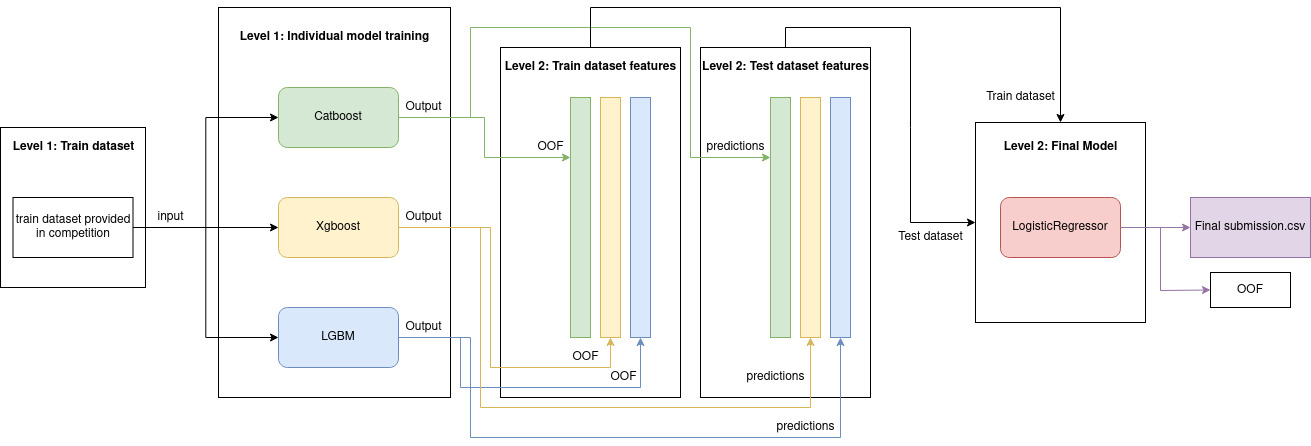

# Imports

In [ ]:
import pandas as pd
import numpy as np
import datatable as dt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Load OOF stored by following notebooks

1. https://www.kaggle.com/aayush26/tps-nov-2021-catboost-301-w-oof
2. https://www.kaggle.com/aayush26/tps-nov-2021-xgboost-301-w-oof
3. https://www.kaggle.com/aayush26/tps-nov-2021-lgbm-301-w-oof/ 

In [ ]:
catboost_oof = np.load('../input/tps-nov-2021-catboost-301-w-oof/oof_catboost.npz')['arr_0']
xgboost_oof = np.load('../input/tps-nov-2021-xgboost-301-w-oof/oof_xgboost.npz')['arr_0']
lgbm_oof = np.load('../input/tps-nov-2021-lgbm-301-w-oof/oof_lgbm.npz')['arr_0']

# Load train set to use only the target column

In [ ]:
train = dt.fread('../input/tabular-playground-series-nov-2021/train.csv').to_pandas()
y = train['target']
del train

# Load test predictions from catboost, lgbm and xgboost and use as features in level 2

In [ ]:
test_catboost = pd.read_csv("../input/tps-nov-2021-catboost-301-w-oof/submission_catboost_1.csv")
test_xgboost = pd.read_csv("../input/tps-nov-2021-xgboost-301-w-oof/submission_xgboost_1.csv")
test_lgbm = pd.read_csv("../input/tps-nov-2021-lgbm-301-w-oof/submission_lgbm_1.csv")

# Concatenate train OOFs and test predictions to make train and test data set respectively

In [ ]:
stack_x_train = pd.DataFrame({'x': catboost_oof, 'y': xgboost_oof, 'z': lgbm_oof})
stack_x_test = pd.DataFrame({'x': test_catboost.target, 'y': test_xgboost.target, 'z': test_lgbm.target})

# 5-fold model training and prediction

In [ ]:
folds = KFold(n_splits = 5, random_state = 102021, shuffle = True)

predictions = np.zeros(len(stack_x_test))
lr_oof = np.zeros(stack_x_train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(folds.split(stack_x_train)):

    X_train, X_test = stack_x_train.iloc[trn_idx], stack_x_train.iloc[val_idx]
    y_train, y_test = y.iloc[trn_idx], y.iloc[val_idx]

    model = LogisticRegression(n_jobs = -1, random_state = 102021, C = 5, max_iter = 2000)
    print(f"model fit started for Fold: {fold}")
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    lr_oof[val_idx] = pred
    roc = roc_auc_score(y_test, pred)
    print(f" roc_auc_score: {roc}")
    print("-"*50)
    
    predictions += model.predict_proba(stack_x_test)[:,1] / folds.n_splits 

# Store submission and oof

In [ ]:
sub = dt.fread('../input/tabular-playground-series-nov-2021/sample_submission.csv').to_pandas()
sub['target'] = predictions
sub.to_csv(f'submission_stacking_201_1.csv',index = False)
np.savez_compressed('oof_stacking_201.npz', lr_oof)